In [229]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import h3
from tqdm import tqdm

print(os.getcwd())

import sys
from pathlib import Path

Path().resolve().parent

# Add utils to path
ROOT_PATH = Path().resolve().parent
print(f"{ROOT_PATH=}")
DATA_RAW_PATH = ROOT_PATH / "for_participants" / "data_parquet"
DATA_PROCESSED_PATH = ROOT_PATH / "for_participants" / "preprocessed_data"
DATA_DF_ALL_PATH = ROOT_PATH / "for_participants" / "merged_dfs" / "df_all.parquet"
# assert DATA_PATH.exists()
sys.path.append(str(ROOT_PATH))
print(f"{DATA_RAW_PATH=}")
print(f"{DATA_PROCESSED_PATH=}")

# ASSIGNMENT_DIR = Path().resolve().parent
# HANDIN_DIR = ASSIGNMENT_DIR / 'handin'
OUTPUT_DIR = ROOT_PATH / 'output'

def read_data(file_name, path = DATA_RAW_PATH):
    df_tmp = pd.read_parquet(path / f'{file_name}.parquet')
    print(df_tmp.shape)
    return df_tmp


import warnings
warnings.filterwarnings('ignore')

/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/TB
ROOT_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025')
DATA_RAW_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/for_participants/data_parquet')
DATA_PROCESSED_PATH=PosixPath('/Users/tymoteuszbarcinski/DTU/WEC2025/wec2025/for_participants/preprocessed_data')


# Holidays

In [230]:
import holidays
import pandas as pd

def create_holiday_dataframe(year, country_holidays):
    """
    Create a DataFrame with each day in the year and a column indicating if it's a holiday.

    Args:
        year (int): The year for which to generate the DataFrame.
        country_holidays (holidays.HolidayBase): A holidays object for the country.

    Returns:
        pd.DataFrame: A DataFrame with columns ['date', 'is_holiday'].
    """
    # Get all holidays for the specified year
    holiday_dates = set(country_holidays.keys())

    # Create a date range for the entire year
    date_range = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31")

    # Create a DataFrame with the date range
    df = pd.DataFrame({"date": date_range})

    # Add a column indicating whether each date is a holiday
    df["is_holiday"] = df["date"].isin(holiday_dates).astype(int)  # 1 for holiday, 0 otherwise

    return df

# Example usage
year = 2024
poland_holidays = holidays.Poland(years=year)
df_holidays = create_holiday_dataframe(year, poland_holidays)

# Display the resulting DataFrame
print(df_holidays.head())

        date  is_holiday
0 2024-01-01           1
1 2024-01-02           0
2 2024-01-03           0
3 2024-01-04           0
4 2024-01-05           0


# Mergowanie

In [231]:
cols_to_drop = ["station_id", "date", "street",	"segment", "lat", "lon", "h3res13"]
traffic_data = pd.read_parquet("../for_participants/data_parquet/traffic_train.parquet")

df1 = pd.read_parquet("../SG/dfs_processed/df_buildings_agg.parquet")
df2 = pd.read_parquet("../SG/dfs_processed/df_demo_agg.parquet")
df3 = pd.read_parquet("../SG/dfs_processed/df_pois_agg.parquet")
df4 = pd.read_parquet("../SG/dfs_processed/df_roads_agg.parquet")
df5 = pd.read_parquet("../SG/dfs_processed/df_pois_agg_wd.parquet")

df_all = traffic_data

df_all = df_all.merge(df1, left_on = "h3res13", right_on = "h3res13")
df_all = df_all.merge(df2, left_on = "h3res13", right_on = "h3res13")
df_all = df_all.merge(df3, left_on = "h3res13", right_on = "h3res13")
df_all = df_all.merge(df4, left_on = "h3res13", right_on = "h3res13")
df_all = df_all.merge(df5, left_on = "h3res13", right_on = "station_h3")

In [232]:
df_all['station_id'].unique().shape

(65,)

In [233]:
df_meteo = pd.read_parquet("../for_participants/data_parquet/meteo.parquet")

df_meteo['date'] = pd.to_datetime(pd.to_datetime(df_meteo['time']).dt.date)
df_meteo['hour'] = pd.to_datetime(df_meteo['time']).dt.hour
df_meteo = df_meteo.drop(columns = ["time"])
df_all['date'] = pd.to_datetime(df_all['date'])

In [234]:
df_all = df_all.merge(
    df_meteo.drop(columns = ["station_id", 'lon', 'lat']),
    left_on = ["date", "hour", "h3res13"],
    right_on = ["date", "hour", "h3res13"],
    how = "left"
)

In [235]:
df_signals_features = pd.read_parquet("../for_participants/preprocessed_data/df_signals_preprocessed.parquet")
df_signals_features['date'] = pd.to_datetime(df_signals_features['date'])

In [236]:
df_all = df_all.merge(
    df_signals_features,
    left_on = ["date", "hour", "h3res13"],
    right_on = ["date", "hour", "h3res13"],
    how = "left"
)

In [237]:
df_all = df_all.merge(df_holidays, left_on = "date", right_on = "date", how = "left")

# FEATURES

In [238]:
df_all['dayofweek'] = df_all['date'].dt.dayofweek
df_all['weekedn'] = df_all['dayofweek'].isin([5, 6]).astype(int)

df_all['date_hour'] = df_all['date'].astype(str) + "-" + df_all['hour'].astype(str)
df_all['date_station'] = df_all['date'].astype(str) + "-" + df_all['station_id'].astype(str)

df_all.columns = df_all.columns.str.replace('.', '_', regex=False)

In [239]:
df_all.to_parquet("../merged_dfs/df_all.parquet")
df_all.to_csv("../merged_dfs/df_all.csv")

In [240]:
numeric_columns = df_all.select_dtypes(include=['float', 'int'])
correlations_with_traffic = numeric_columns.corr()['traffic']

In [241]:
df_cleaned = correlations_with_traffic.drop(columns=[col for col in correlations_with_traffic.index if 'ctd' in col])

In [242]:
df_cleaned = df_cleaned[[col for col in correlations_with_traffic.index if 'ctd' not in col]]
df_cleaned = df_cleaned[[col for col in df_cleaned.index if 'ctn' not in col]]

In [243]:
[col for col in correlations_with_traffic.index if 'ctd' in col]

['signal_ctd_m_25_0',
 'signal_ctd_m_50_0',
 'signal_ctd_m_75_0',
 'signal_ctd_m_100_0',
 'signal_ctd_m_125_0',
 'signal_ctd_m_250_0',
 'signal_ctd_m_500_0',
 'signal_ctd_rho_85',
 'signal_ctd_rho_90',
 'signal_ctd_rho_95',
 'signal_ctd_rho_98']

In [244]:
df_cleaned.abs().sort_values().tail(25)

mass_media_10_y                              0.206546
mass_media_10_x                              0.206546
home_service_5_x                             0.206934
home_service_5_y                             0.206934
relative_humidity_2m                         0.209458
private_establishments_and_corporates_5_y    0.209696
private_establishments_and_corporates_5_x    0.209696
Work_1                                       0.213337
roads_intensity_2_0_1                        0.215439
business_to_business_5_y                     0.217113
business_to_business_5_x                     0.217113
Residential_1                                0.217442
travel_5_x                                   0.219007
travel_5_y                                   0.219007
Residential_2                                0.220212
Residential_0_5                              0.222546
roads_intensity_1_0_1                        0.228627
Residential_1_5                              0.245633
hour                        

In [245]:
plt.scatter(df_all['automotive_5'], df_all['traffic'])

KeyError: 'automotive_5'

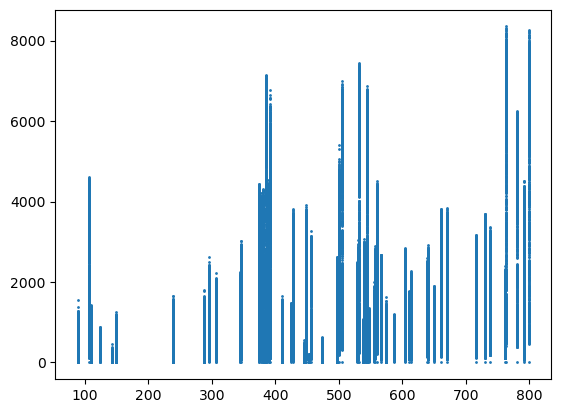

In [ ]:
plt.scatter(df_all['automotive_5'], df_all['traffic'], s=1)

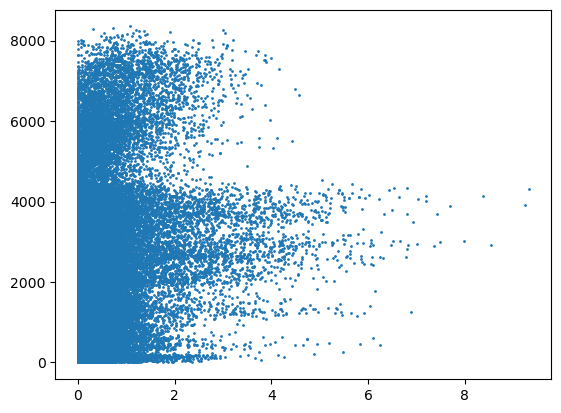

In [ ]:
plt.scatter(df_all['signal_ctd_m_100_0'], df_all['traffic'], s=1)

In [ ]:
df_all['station_id']

0         1366
1         1366
2         1366
3         1366
4         1366
          ... 
101011    3332
101012    3332
101013    3332
101014    3332
101015    3332
Name: station_id, Length: 101016, dtype: object